# Predict Credit card Approval
Made by
- Yannick K. Hartington

The task here is to build a machine learning model to predict if an applicant is a 'good' or 'bad' client, were the definition of 'good' or 'bad' is not given. Thus, we need to find a way to construct the labels. Lastly, imbalance data problem is a big problem in this task, which also needs to be handle. 

# Table of content

- [Data Overview](#data-overview)
    - [Application record](#application-record)
    - [Credit record](#credit-record)
- [Data Preprocessing](#data-preprocessing)
- [Response variable](#response-variable)

### Import necessary libraries

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import numpy as np

### Load datasets

In [2]:
dataset_path = r'/mnt/c/Datasets/Credit Card Approval' # WSL
#dataset_path = r'C:\Datasets\Credit card approval' # Windows

application_record_path = os.path.join(dataset_path, 'application_record.csv')
credit_record_path = os.path.join(dataset_path, 'credit_record.csv')

In [3]:
application_record_df = pd.read_csv(application_record_path)
credit_record_df = pd.read_csv(credit_record_path)

## Data Overview
We will start out with inspecting the two datasets to achieve a better understanding of them. This will also enable us to get a better idea if and how we should transform some of the features.

But first a little information about the two datasets we have.
- application_record.csv contains appliers personal information
- credit_record.csv records users' behaviors of credit card
- They are connected by the ID column

Further information regarding the datasets and their features can be found [here](https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction/data). However, I find it necessary to describe a few features in the datasets. 

The application_record dataset contains two of these features:
- **DAYS_BIRTH** is the number of days since the person was born. It count backward from current day (0). Thus -1 means yesterday.
- **DAYS_EMPLOYED** is how many days the person has been employed. It count backward from current day (0) and if the number is positive, it means the person is currently unemployed.

The credit_record dataset do also contains two of these:
- **MONTHS_BALANCE** is the month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on.
- **STATUS** contains one of the following categories:
    - 0: 1-29 days past due 
    - 1: 30-59 days past due 
    - 2: 60-89 days overdue 
    - 3: 90-119 days overdue 
    - 4: 120-149 days overdue 
    - 5: Overdue or bad debts, write-offs for more than 150 days 
    - C: paid off that month 
    - X: No loan for the month

Now lets inspect the two datasets and see if we have to transform any of the features.

### Application record


In [4]:
application_record_df

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0


In [5]:
application_record_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

By looking at some rows and the summary of the dataset, it was revealed that we have a few things we need to handle:
- **ID** should be converted to strings since the IDs represent the client number, which is categorical and have no numerical value.
- The binary encoding features are not constructed the same way since some contains "Y" for yes and "N" for no and others use 1 for yes and 0 for no. We would like the latter. Thus, the features we need to transform is:
    - **FLAG_OWN_CAR**
    - **FLAG_OWN_REALTY**
- **OCCUPATION_TYPE** contains alot of missing values, which we have to look further into. 

These things will be handled in the *Data Preprocessing* section.

### Credit record

In [6]:
credit_record_df

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
...,...,...,...
1048570,5150487,-25,C
1048571,5150487,-26,C
1048572,5150487,-27,C
1048573,5150487,-28,C


In [7]:
credit_record_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


Also for this dataset should we convert the **ID** to strings.

## Data Preprocessing


### Application record

#### ID

In [8]:
# Convert ID to strings
application_record_df['ID'] = application_record_df['ID'].astype(str)

Next we check if the ID column is unique 

In [9]:
application_record_df['ID'].is_unique

False

Lets have a look on the rows, where the ID occurs more than once

In [10]:
dublicates = application_record_df.duplicated(subset=['ID'], keep=False)
application_record_df[dublicates].sort_values(by='ID')

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
426818,7022197,M,Y,Y,3,135000.0,Working,Secondary / secondary special,Married,House / apartment,-11945,-735,1,0,0,1,Laborers,5.0
425023,7022197,F,N,Y,0,450000.0,Commercial associate,Higher education,Separated,House / apartment,-19813,-1799,1,0,0,1,NaN,1.0
431545,7022327,F,N,Y,0,135000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-14771,-5298,1,0,0,0,High skill tech staff,1.0
431911,7022327,M,Y,Y,0,256500.0,Commercial associate,Higher education,Married,House / apartment,-21503,-1674,1,0,0,1,Core staff,2.0
425486,7023108,M,Y,Y,1,67500.0,Working,Secondary / secondary special,Married,House / apartment,-15156,-1696,1,1,0,0,Core staff,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426563,7836711,F,N,Y,2,292500.0,Working,Higher education,Married,House / apartment,-13747,-4386,1,0,1,0,Accountants,4.0
421464,7836971,M,Y,N,1,157500.0,Working,Secondary / secondary special,Married,House / apartment,-13771,-5520,1,0,0,0,NaN,3.0
428620,7836971,F,N,Y,0,103500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-13383,-2798,1,0,1,0,Sales staff,2.0
422068,7838075,M,N,Y,0,337500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-18198,-1275,1,0,0,1,Drivers,2.0


It does not look like the rows are duplicates and we can not tell which are correct, so we are going to remove these from the dataset.

In [11]:
application_record_df = application_record_df[~dublicates]
application_record_df['ID'].is_unique # Check that the ID column is now unique 

True

In [12]:
# Make the ID as the index
application_record_df = application_record_df.set_index('ID')

#### FLAG_OWN_CAR & FLAG_OWN_REALTY

In [13]:
application_record_df['FLAG_OWN_CAR']

ID
5008804    Y
5008805    Y
5008806    Y
5008808    N
5008809    N
          ..
6840104    N
6840222    N
6841878    N
6842765    N
6842885    N
Name: FLAG_OWN_CAR, Length: 438463, dtype: object

In [14]:
application_record_df['FLAG_OWN_CAR'].replace({'Y': 1, 'N': 0}, inplace=True)

In [15]:
# Replace 'Y' with 1 and 'N' with 0 
application_record_df['FLAG_OWN_CAR'] = application_record_df['FLAG_OWN_CAR'].replace({'Y': 1, 'N': 0})
application_record_df['FLAG_OWN_REALTY'] = application_record_df['FLAG_OWN_REALTY'].replace({'Y': 1, 'N': 0})

#### Missing values
Lets get a better view of OCCUPATION_TYPE, which was the only feature with missing values

In [16]:
# Count of different values including NaN
application_record_df['OCCUPATION_TYPE'].value_counts(dropna=False)

OCCUPATION_TYPE
NaN                      134177
Laborers                  78225
Core staff                42993
Sales staff               41092
Managers                  35477
Drivers                   26085
High skill tech staff     17283
Accountants               15980
Medicine staff            13518
Cooking staff              8074
Security staff             7993
Cleaning staff             5843
Private service staff      3455
Low-skill Laborers         2140
Secretaries                2044
Waiters/barmen staff       1665
Realty agents              1041
HR staff                    774
IT staff                    604
Name: count, dtype: int64

In [17]:
# Percentage of different values including NaN
application_record_df['OCCUPATION_TYPE'].value_counts(normalize=True, dropna=False) * 100

OCCUPATION_TYPE
NaN                      30.601670
Laborers                 17.840730
Core staff                9.805388
Sales staff               9.371828
Managers                  8.091219
Drivers                   5.949191
High skill tech staff     3.941724
Accountants               3.644549
Medicine staff            3.083042
Cooking staff             1.841432
Security staff            1.822959
Cleaning staff            1.332610
Private service staff     0.787980
Low-skill Laborers        0.488069
Secretaries               0.466174
Waiters/barmen staff      0.379736
Realty agents             0.237420
HR staff                  0.176526
IT staff                  0.137754
Name: proportion, dtype: float64

So, OCCUPATION_TYPE is missing about 31% of its values. One way to deal with the rows that are missing data, is simply to remove them from our dataset. However, there is no clear category for unemployed. Thus, you could argue would be the missing values. I will therefore replace the missing values with the string "Unemployed", so they are also represented in the dataset. Howerver, be aware that this could be a misinterpretation of the data.

In [18]:
# Replace missing values with 'Unemployed'
application_record_df['OCCUPATION_TYPE'] = application_record_df['OCCUPATION_TYPE'].fillna('Unemployed')
application_record_df['OCCUPATION_TYPE'].value_counts(dropna=False)

OCCUPATION_TYPE
Unemployed               134177
Laborers                  78225
Core staff                42993
Sales staff               41092
Managers                  35477
Drivers                   26085
High skill tech staff     17283
Accountants               15980
Medicine staff            13518
Cooking staff              8074
Security staff             7993
Cleaning staff             5843
Private service staff      3455
Low-skill Laborers         2140
Secretaries                2044
Waiters/barmen staff       1665
Realty agents              1041
HR staff                    774
IT staff                    604
Name: count, dtype: int64

### Credit record

#### ID

In [19]:
# Convert ID to strings
credit_record_df['ID'] = credit_record_df['ID'].astype(str)

## Response variable
We need to construct the labels of who is a 'good' and 'bad' client, however I do not have a lot of knowledge in this specific domain. Thus I have chosen to use a simple method, which just put every client that have been more than 60 days overdue, as a bad client.

In [20]:
risk_ids = credit_record_df[credit_record_df['STATUS'].isin(['2', '3', '4', '5'])]['ID'].drop_duplicates()

application_record_df['RISK'] = application_record_df.index.isin(risk_ids).astype(int)

In [21]:
sum_of_risky_ids = application_record_df['RISK'].sum()
percentage_ones = (sum_of_risky_ids / len(application_record_df.index)) * 100

print(f"The sum of risky IDs: {sum_of_risky_ids}")
print(f"Percentage of risky IDs: {percentage_ones:.2f}%")

The sum of risky IDs: 616
Percentage of risky IDs: 0.14%


In [22]:
application_record_df

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,RISK
ID,,,,,,,,,,,,,,,,,,
5008804,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,Unemployed,2.0,0
5008805,M,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,Unemployed,2.0,0
5008806,M,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0
5008808,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
5008809,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840104,M,0,1,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,Unemployed,1.0,0
6840222,F,0,0,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0,0
6841878,F,0,0,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0,0


## Exploratory Data Analysis (EDA)
Now, lets perform an EDA, which will be done to examine the dataset and summarize the main characteristics. This will among other things help us understand the data even better, detect patterns and spot anomalies.

### Application record

In [23]:
categorical_cols = application_record_df.select_dtypes(include=['object']).columns
numerical_cols = application_record_df.select_dtypes(include=[np.number]).columns

# Check for binary columns within numerical columns
binary_cols = [col for col in numerical_cols if 'FLAG' in col]

# Remove binary columns from numerical columns list
numerical_cols = [col for col in numerical_cols if col not in binary_cols]

In [24]:
print('Categorical columns:\n', categorical_cols)
print('')
print('Numerical columns:\n', numerical_cols)
print('')
print('Binary columns:\n', binary_cols)

Categorical columns:
 Index(['CODE_GENDER', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE'],
      dtype='object')

Numerical columns:
 ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS', 'RISK']

Binary columns:
 ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL']


#### Categorical

In [25]:
num_columns = len(categorical_cols)
cols = 2  # Number of plots per row
rows = (num_columns + cols - 1) // cols  # Calculate the number of rows needed

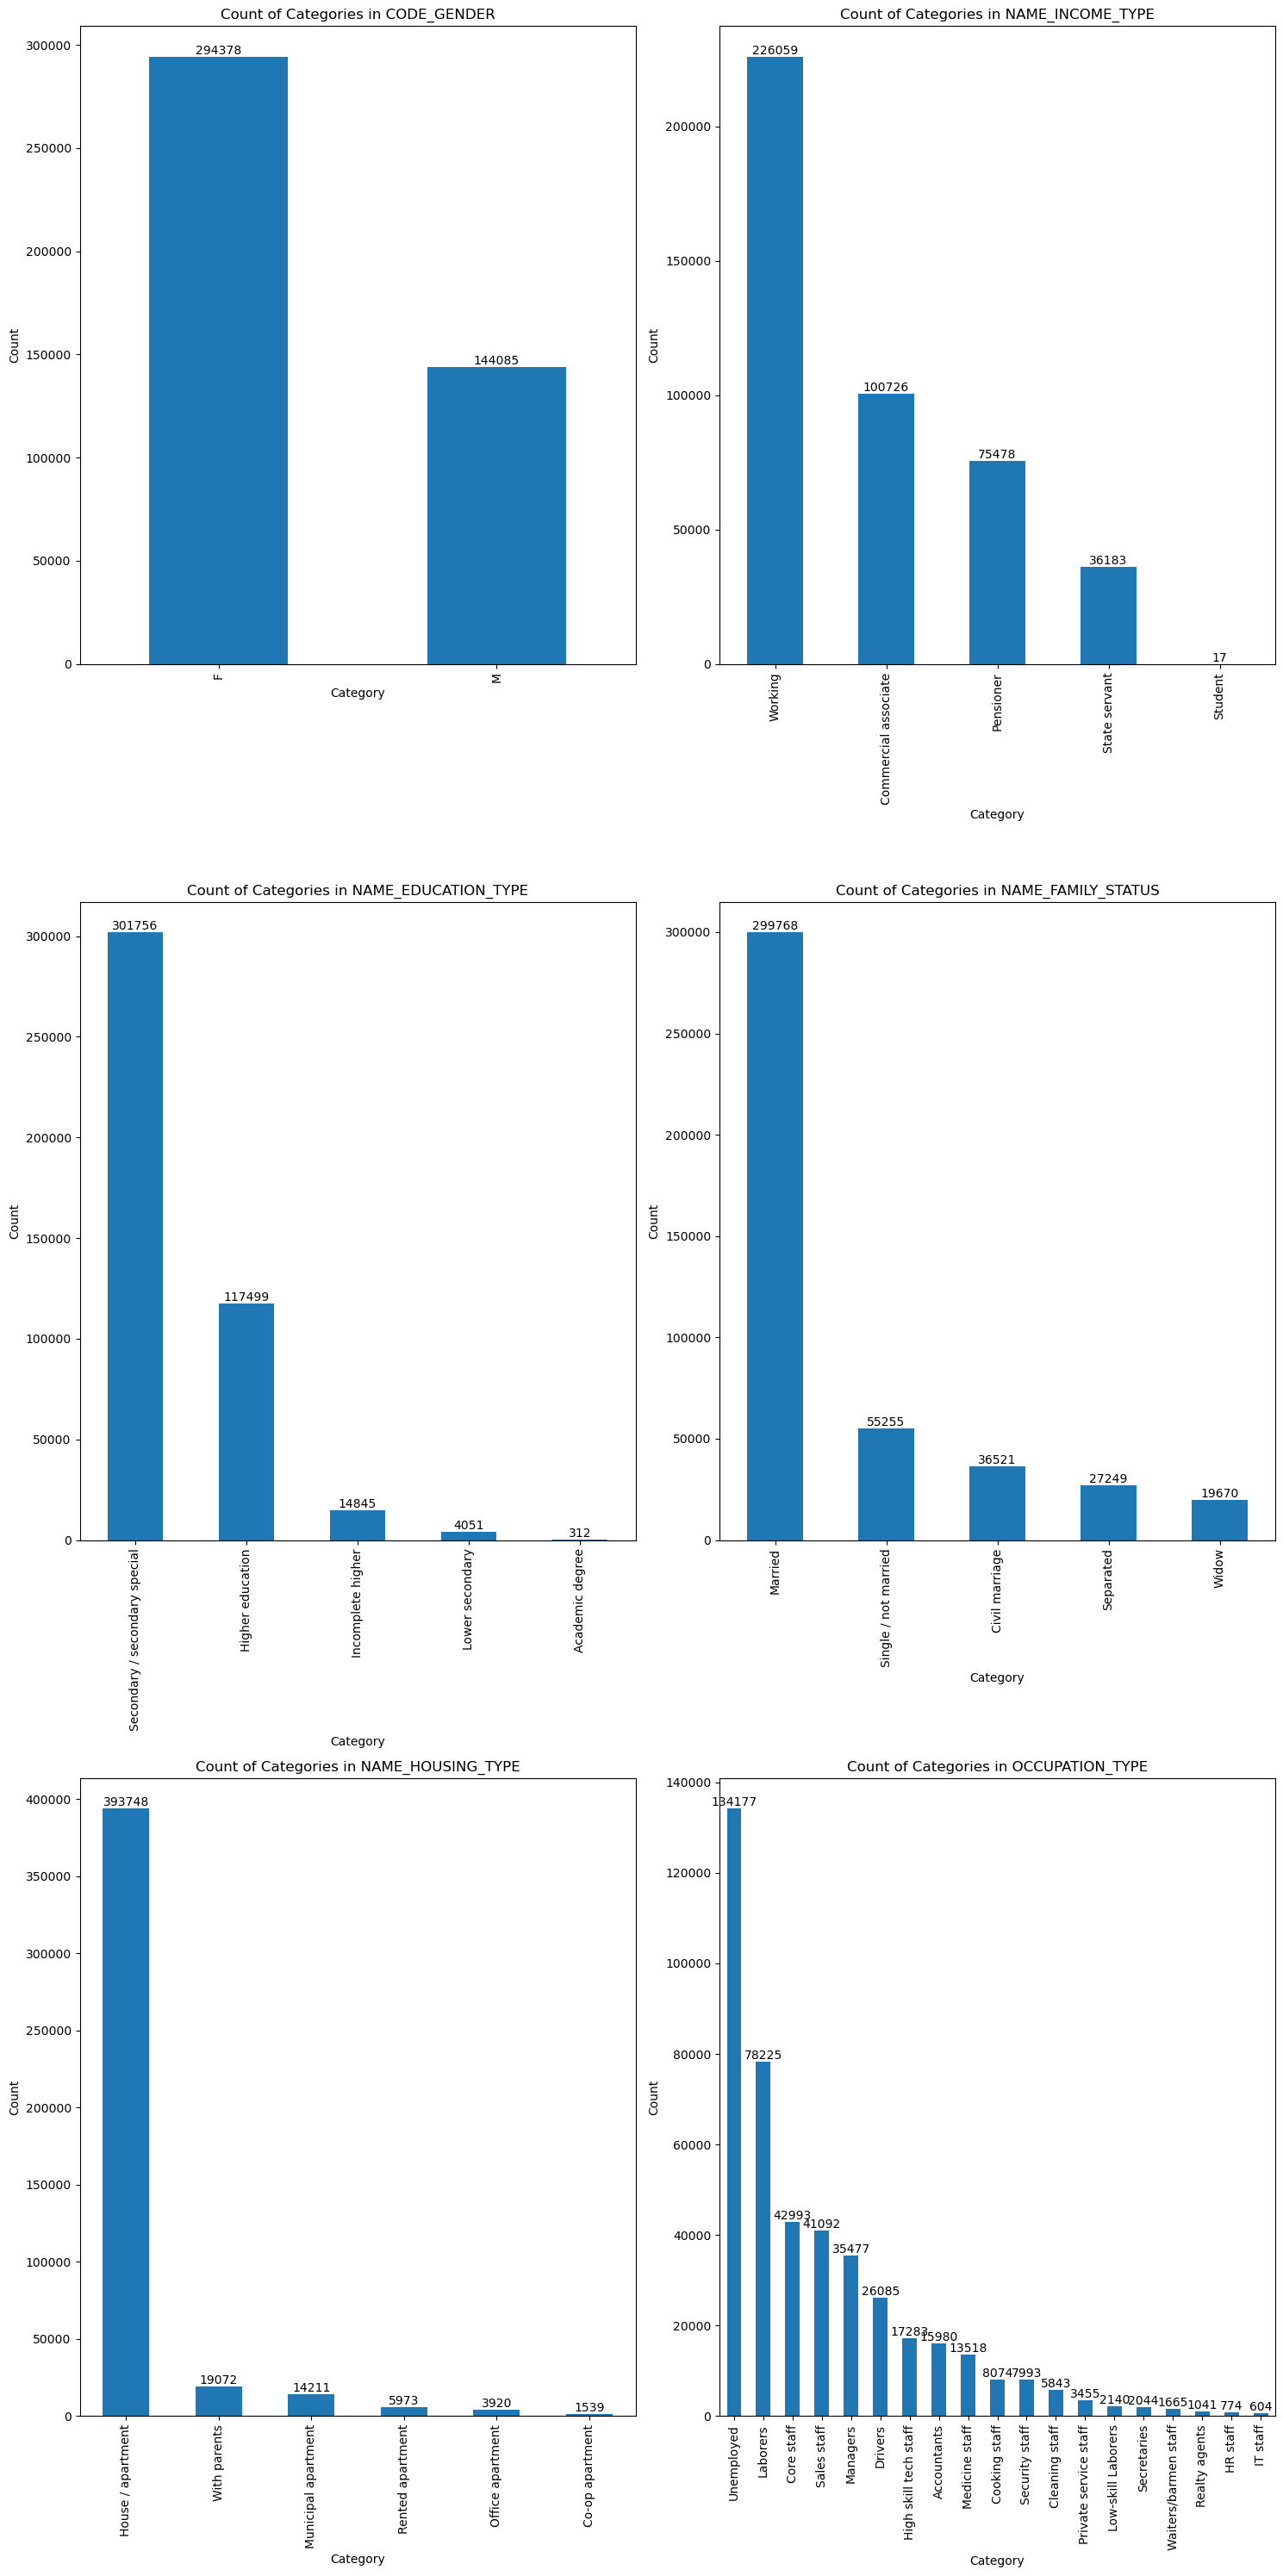

In [32]:
fig, axes = plt.subplots(rows, cols, figsize=(15, 10 * rows))

for i, column in enumerate(categorical_cols):
    row, col = divmod(i, cols)
    category_counts = application_record_df[categorical_cols][column].value_counts()
    ax = category_counts.plot(kind='bar', ax=axes[row, col])
    ax.set_xlabel('Category')
    ax.set_ylabel('Count')
    ax.set_title(f'Count of Categories in {column}')

    # Annotate the bars
    for j, count in enumerate(category_counts):
        ax.text(j, count, str(count), ha='center', va='bottom')     
        
plt.tight_layout()
plt.show()

Det under skal lige overvejes! Det er svært at se noget

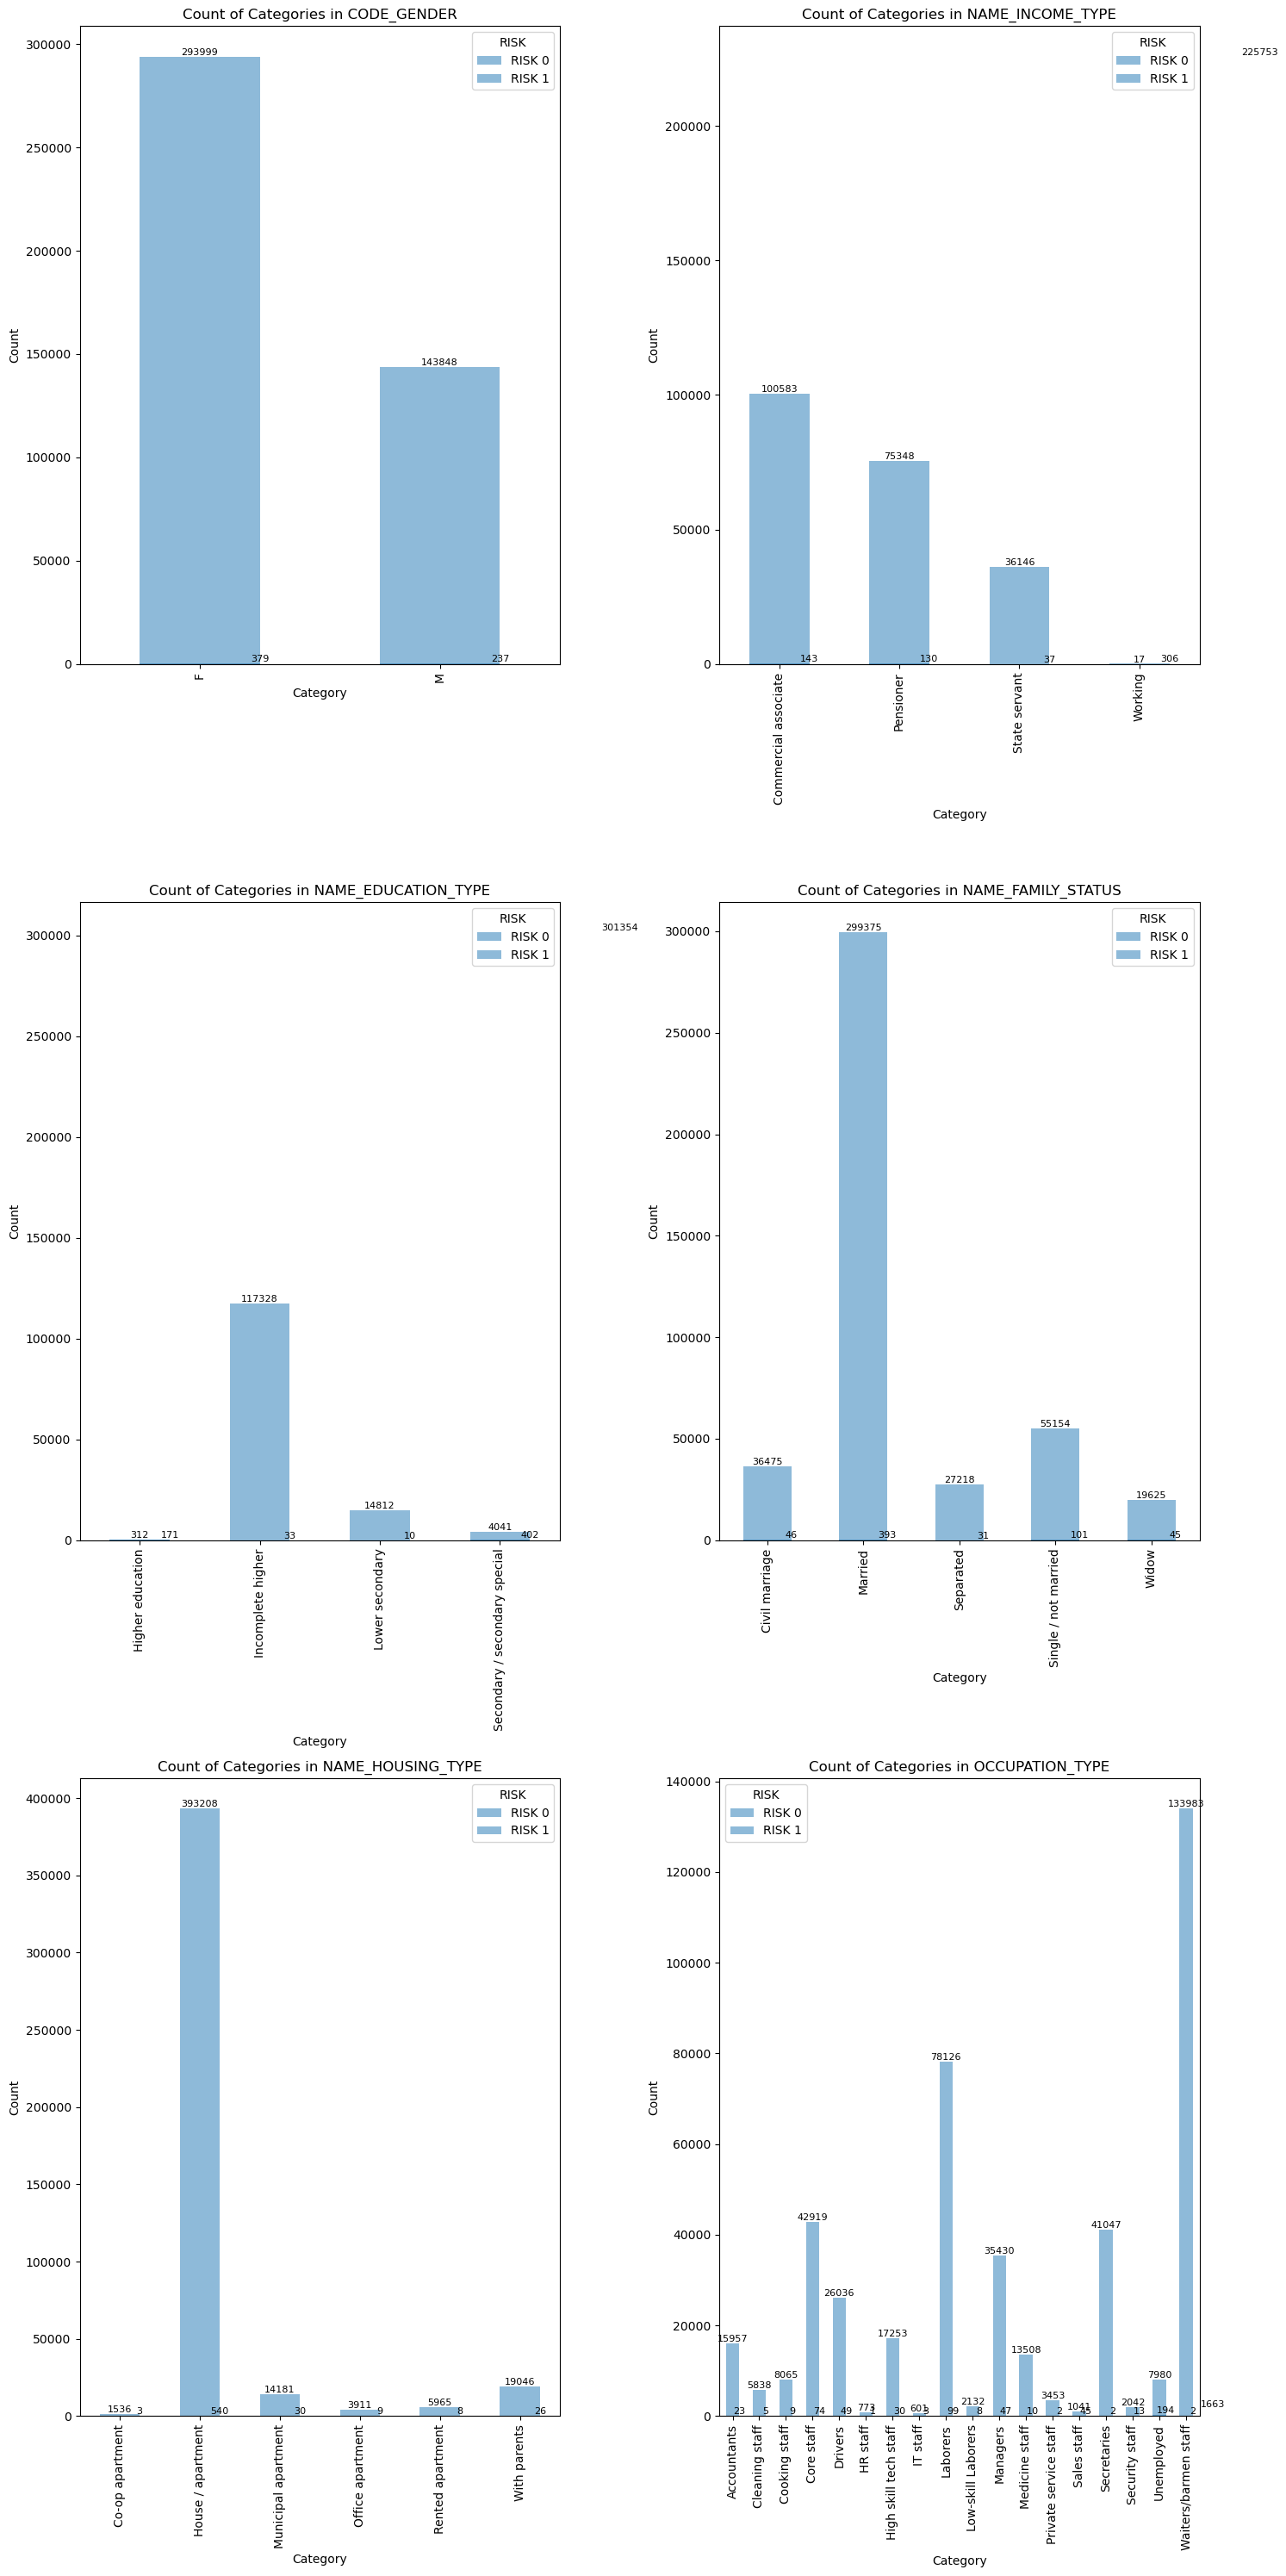

In [34]:
fig, axes = plt.subplots(rows, cols, figsize=(15, 10 * rows))

# Group the data by 'RISK' and iterate over each group
grouped = application_record_df.groupby('RISK')

for i, column in enumerate(categorical_cols):
    row, col = divmod(i, cols)
    ax = axes[row, col]

    for risk, group in grouped:
        category_counts = group[column].value_counts().sort_index()
        category_counts.plot(kind='bar', ax=ax, alpha=0.5, label=f'RISK {risk}')
    
    ax.set_xlabel('Category')
    ax.set_ylabel('Count')
    ax.set_title(f'Count of Categories in {column}')
    ax.legend(title='RISK')

    # Annotate the bars
    for j, (risk, group) in enumerate(grouped):
        category_counts = group[column].value_counts().sort_index()
        for k, count in enumerate(category_counts):
            ax.text(k + (j * 0.25), count, str(count), ha='center', va='bottom', fontsize=8)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

#### Numerical

In [34]:
application_record_df[numerical_cols].describe()

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS
count,438463.000000,4.384630e+05,438463.000000,438463.000000,438463.000000
mean,0.427384,1.875220e+05,-15997.934334,60564.534488,2.194461
std,0.724879,1.100832e+05,4185.044293,138768.684097,0.897194
min,0.000000,2.610000e+04,-25201.000000,-17531.000000,1.000000
25%,0.000000,1.215000e+05,-19484.000000,-3103.000000,2.000000
50%,0.000000,1.611000e+05,-15630.000000,-1468.000000,2.000000
75%,1.000000,2.250000e+05,-12514.000000,-371.000000,3.000000
max,19.000000,6.750000e+06,-7489.000000,365243.000000,20.000000


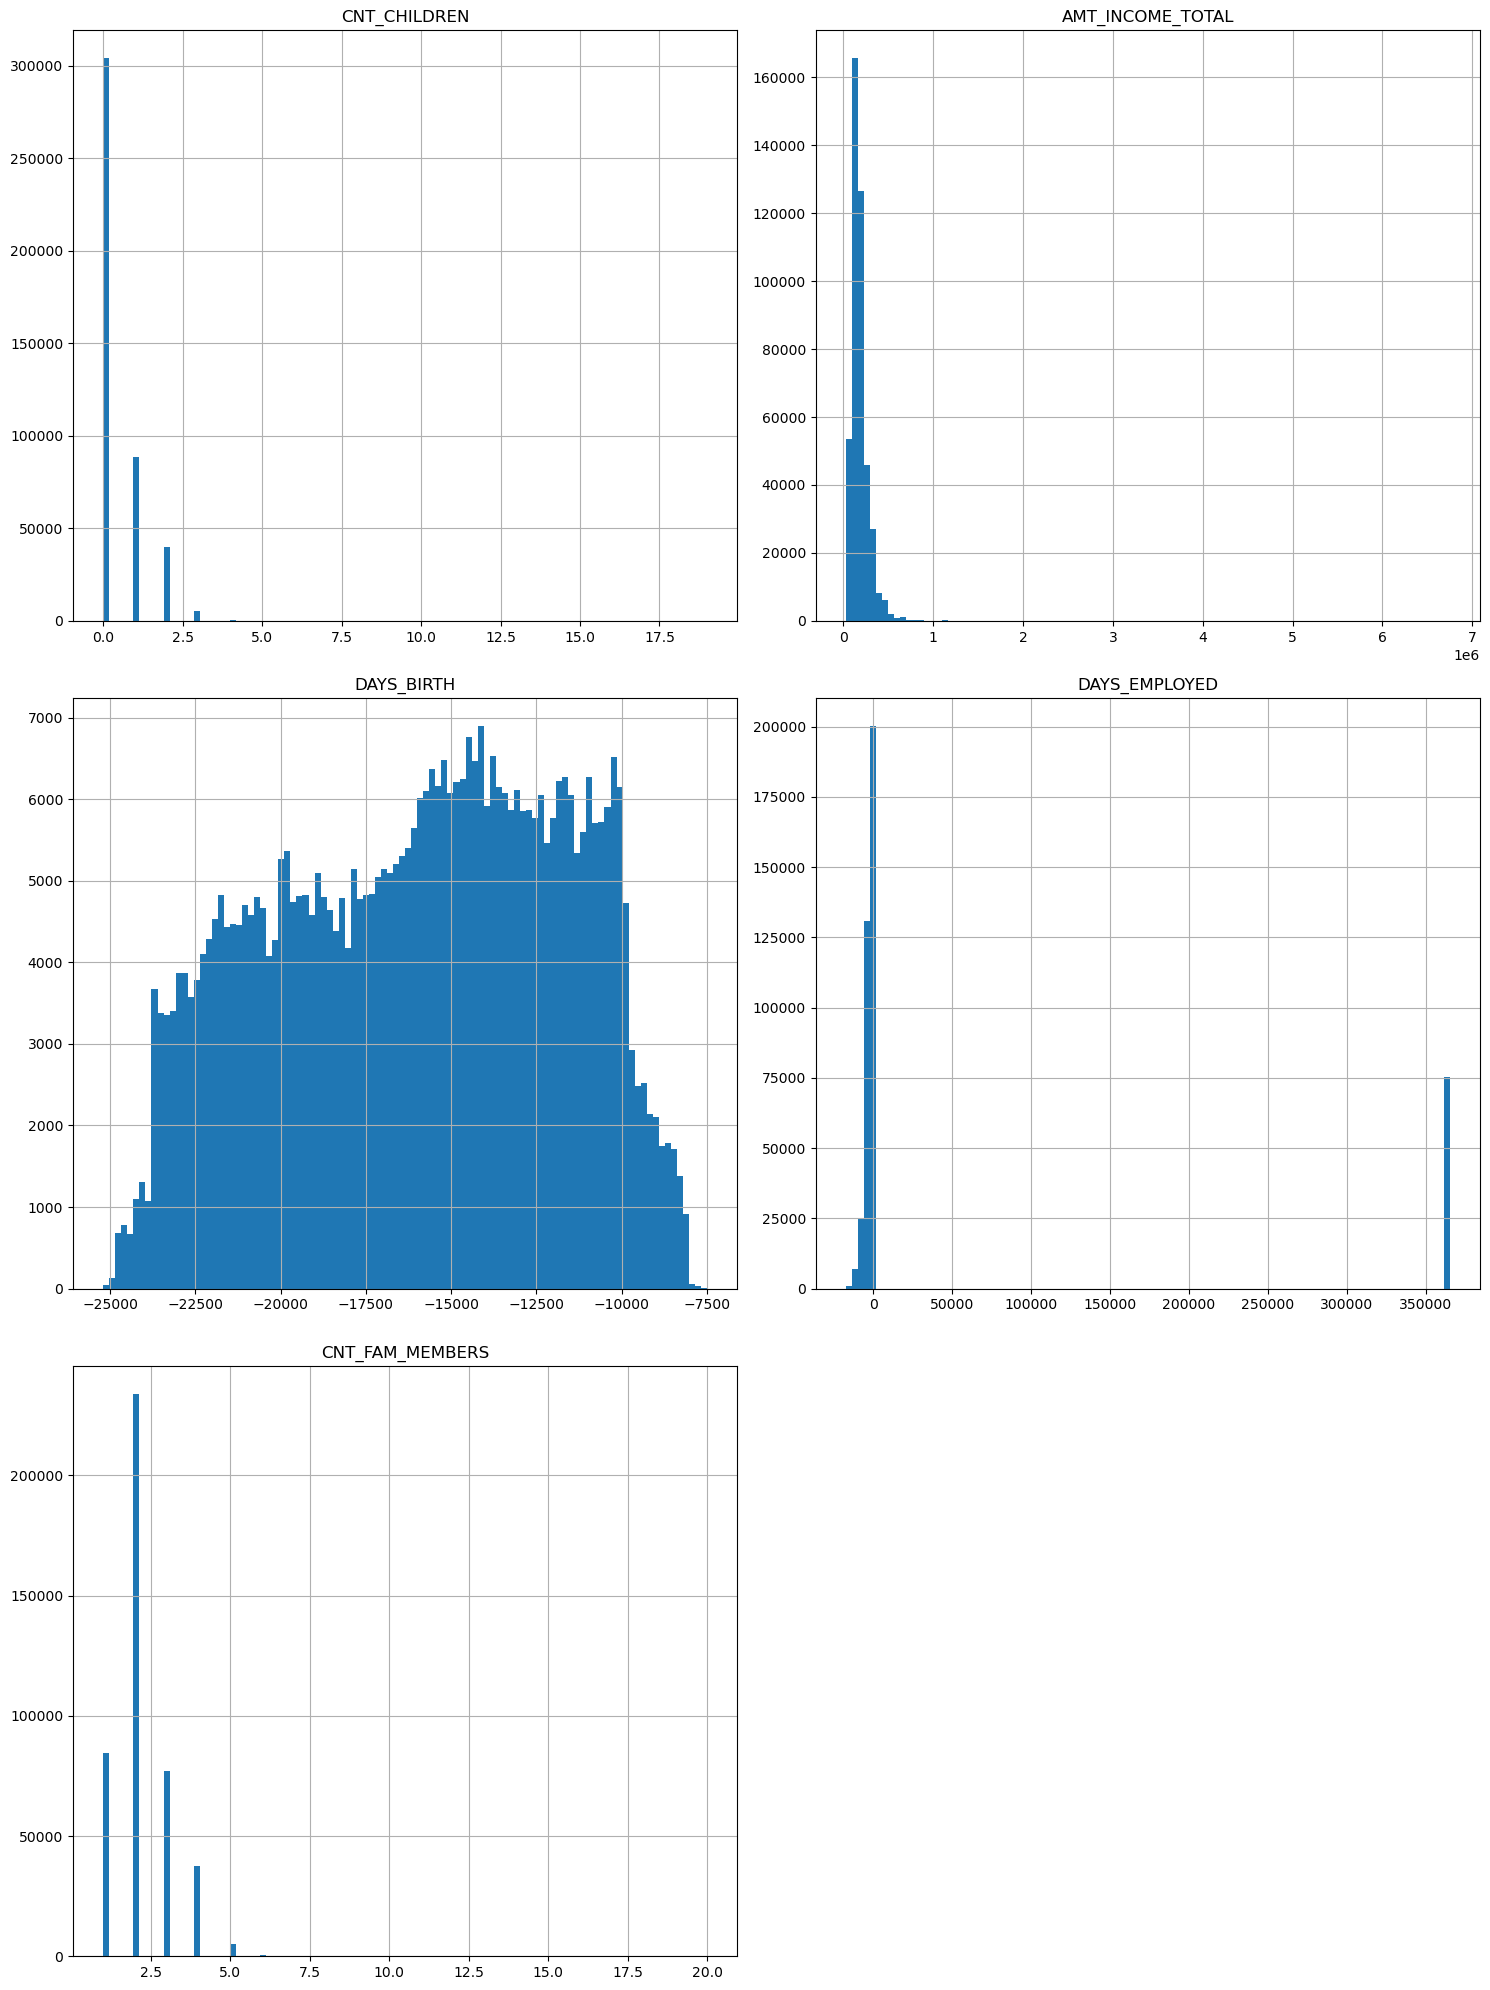

In [35]:
num_columns = len(numerical_cols)
cols = 2  # Number of plots per row
rows = (num_columns + cols - 1) // cols  # Calculate the number of rows needed

# Plot histograms for numerical columns
application_record_df[numerical_cols].hist(bins=100, figsize=(15, 20), layout=(rows, cols))
plt.tight_layout()
plt.show()

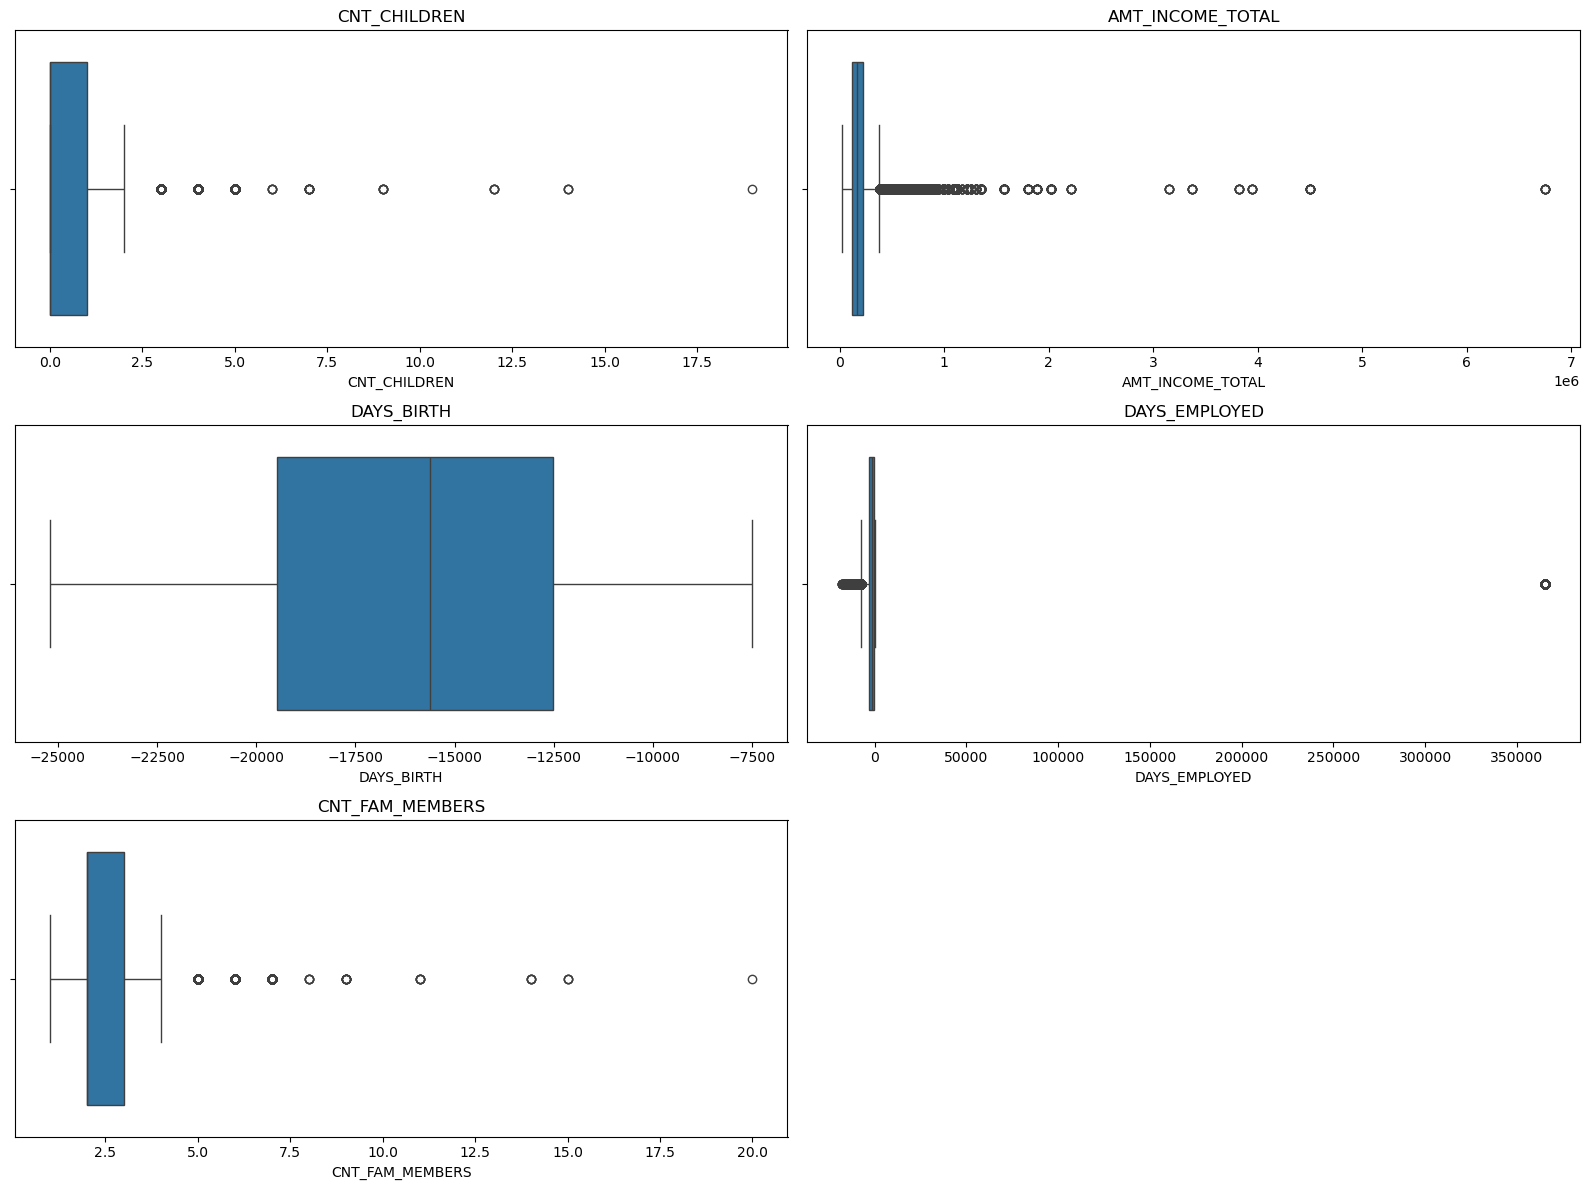

In [36]:
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 4 * rows))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each numerical column in a separate subplot
for i, col in enumerate(numerical_cols):
    sns.boxplot(application_record_df[numerical_cols][col], orient="h", ax=axes[i])
    axes[i].set_title(col)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

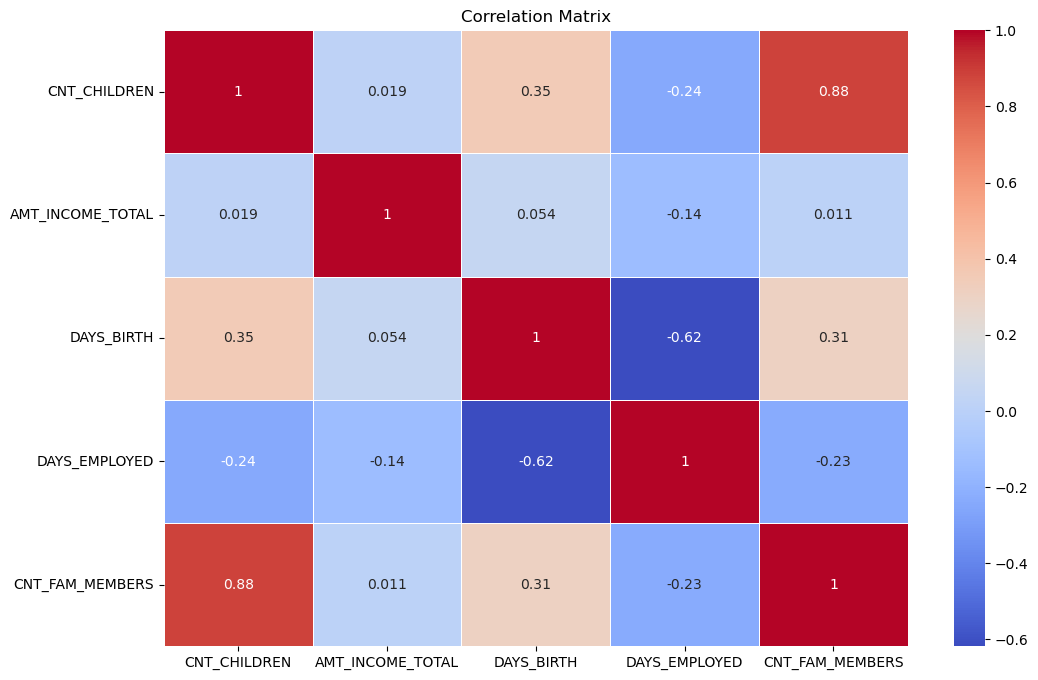

In [37]:
# Compute correlation matrix
correlation_matrix = application_record_df[numerical_cols].corr()

# Plot heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

#### Binary

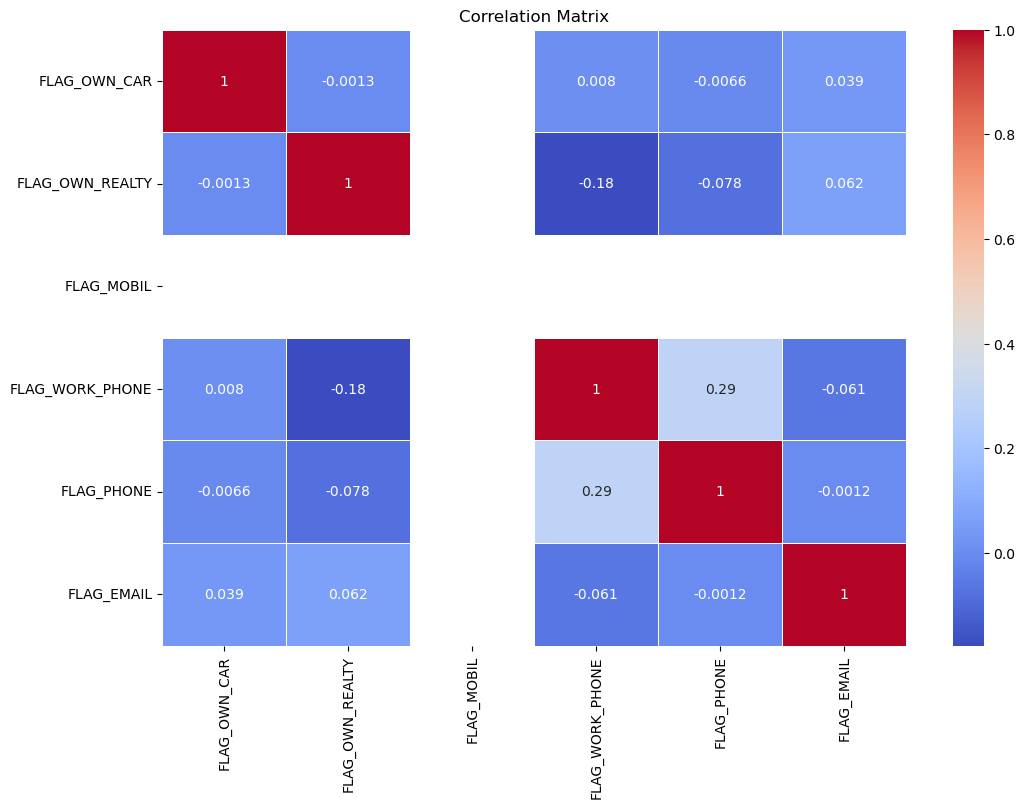

In [105]:
# Compute correlation matrix
correlation_matrix = application_record_df[binary_cols].corr()

# Plot heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### Credit record

In [1]:
categorical_cols = credit_record_df.select_dtypes(include=['object']).columns
numerical_cols = credit_record_df.select_dtypes(include=[np.number]).columns

NameError: name 'credit_record_df' is not defined

## Model Selection
We will try out different kinds of algorithms to see, which one performs the best:
1. Logistic Regression
1. Decision Tree
1. Random Forest
1. Neural Network

## Model traning and Evaluation